In [84]:
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable


In [85]:
from lib import evaluate
from lib.serialize import iter_jl
import pandas as pd
import numpy as np

In [86]:
%reload_ext autoreload
%autoreload 2

In [87]:
dict_genres = {'pop': 0, 'country': 1, 'blues': 2, 'rock': 3, 'jazz': 4, "reggae": 5, "hip hop": 6}

In [88]:
df = pd.read_csv('tcc_ceds_music.csv')
df.shape

(28372, 31)

In [89]:
df['genre'] = df['genre'].apply(lambda x: dict_genres[x])

In [90]:
df["acousticness"] = np.cbrt(df["acousticness"]) # cube root transform

In [91]:
df.shape

(28372, 31)

In [92]:
df.head()

,Unnamed: 0,artist_name,track_name,release_date,genre,lyrics,len,dating,violence,world/life,...,sadness,feelings,danceability,loudness,acousticness,instrumentalness,valence,energy,topic,age
0,0,mukesh,mohabbat bhi jhoothi,1950,0,hold time feel break feel untrue convince spea...,95,0.000598,0.063746,0.000598,...,0.380299,0.117175,0.357739,0.454119,0.999330,0.901822,0.339448,0.137110,sadness,1.0
1,4,frankie laine,i believe,1950,0,believe drop rain fall grow believe darkest ni...,51,0.035537,0.096777,0.443435,...,0.001284,0.001284,0.331745,0.647540,0.984707,0.000002,0.325021,0.263240,world/life,1.0
2,6,johnnie ray,cry,1950,0,sweetheart send letter goodbye secret feel bet...,24,0.002770,0.002770,0.002770,...,0.002770,0.225422,0.456298,0.585288,0.943674,0.000000,0.351814,0.139112,music,1.0
3,10,pérez prado,patricia,1950,0,kiss lips want stroll charm mambo chacha merin...,54,0.048249,0.001548,0.001548,...,0.225889,0.001548,0.686992,0.744404,0.437839,0.199393,0.775350,0.743736,romantic,1.0
4,12,giorgos papadopoulos,apopse eida oneiro,1950,0,till darling till matter know till dream live ...,48,0.001350,0.001350,0.417772,...,0.068800,0.001350,0.291671,0.646489,0.991902,0.000246,0.597073,0.394375,romantic,1.0


In [93]:
train, test = evaluate.date_split(df)

In [94]:
X_train, y_train = evaluate.x_y_split(train)
X_test, y_test = evaluate.x_y_split(test)

In [95]:
evaluate.to_json_lines(X_train,y_train,'train')
evaluate.to_json_lines(X_test,y_test,'test')

In [96]:
X_train, y_train = iter_jl('X_train.jl'), iter_jl('y_train.jl')

In [97]:
X_test, y_test = iter_jl('X_test.jl'), iter_jl('y_test.jl')

In [98]:
X_train = list(X_train)
y_train = list(y_train)
X_test = list(X_test)
y_test = list(y_test)

In [99]:
from lib.transformers import FeatureProjectionFromJson, TargetEncoder, PretrainedFastTextTransformer, TargetEncodeWithNumericalMean, TargetEncodeWithNumericalMaxOutlier, TargetEncodeWithNumericalMinOutlier
from sklearn.pipeline import make_pipeline, make_union

fields = ['age','violence', 
                            'family/gospel','romantic','obscene','movement/places',
                           'light/visual perceptions','family/spiritual','sadness',
                           'danceability','loudness','acousticness','instrumentalness','valence','energy',
                             'dating','like/girls','feelings', 'communication', 'world/life','night/time', 'music'] 
 

features_pipe = make_union(make_pipeline(
        FeatureProjectionFromJson(fields)
),
                           #make_pipeline(FeatureProjectionFromJson(['topic']), OneHotEncoder()),
                           #make_pipeline(FeatureProjectionFromJson(['artist_name']), OneHotEncoder()),
                          make_pipeline(TargetEncodeWithNumericalMean('topic', fields)),
                        
                           make_pipeline(TargetEncodeWithNumericalMean('artist_name', fields)),
                           
                           make_pipeline(PretrainedFastTextTransformer('lyrics_fasttext.bin','lyrics')),
                           
                          )

In [100]:
import lightgbm as lgb
import xgboost as xgb

In [101]:
lgb_pipe = make_pipeline(
    features_pipe,
    lgb.LGBMClassifier(random_state=42, class_weight = 'balanced')
)
lgb_pipe.fit(X_train, y_train)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('pipeline-1',
                                                 Pipeline(steps=[('featureprojectionfromjson',
                                                                  FeatureProjectionFromJson(fields=['age',
                                                                                                    'violence',
                                                                                                    'family/gospel',
                                                                                                    'romantic',
                                                                                                    'obscene',
                                                                                                    'movement/places',
                                                                                                    'light/visual '
                                                                                                    'perceptions',
                                                                                                    'family/spiritual',
                                                                                                    'sadness',
                                                                                                    'danceability',
                                                                                                    'loudness',
                                                                                                    'acousticness',
                                                                                                    'instrumentalness',
                                                                                                    'vale...
                                                                                                                  'acousticness',
                                                                                                                  'instrumentalness',
                                                                                                                  'valence',
                                                                                                                  'energy',
                                                                                                                  'dating',
                                                                                                                  'like/girls',
                                                                                                                  'feelings',
                                                                                                                  'communication',
                                                                                                                  'world/life',
                                                                                                                  'night/time',
                                                                                                                  'music']))])),
                                                ('pipeline-4',
                                                 Pipeline(steps=[('pretrainedfasttexttransformer',
                                                                  PretrainedFastTextTransformer(field='lyrics',
                                                                                                fname='lyrics_fasttext.bin'))]))])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', random_state=42))])

In [102]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def get_metrics_multi(y_true, y_pred):
    dicc = {'f1': f1_score(y_true, y_pred, average = 'macro'),
      'precision': precision_score(y_true, y_pred, average = 'macro'),
      'acc': accuracy_score(y_true, y_pred),
      'recall': recall_score(y_true, y_pred, average = 'macro')}
    print(dicc)
    return(dicc)

In [103]:
get_metrics_multi(y_train,lgb_pipe.predict(X_train))

{'f1': 0.9753118267136897, 'precision': 0.9725036538348902, 'acc': 0.9694136657433057, 'recall': 0.9783326303978416}


{'f1': 0.9753118267136897,
 'precision': 0.9725036538348902,
 'acc': 0.9694136657433057,
 'recall': 0.9783326303978416}

In [104]:
preds = lgb_pipe.predict(X_test)

In [105]:
get_metrics_multi(y_test,preds)

{'f1': 0.6895342158095384, 'precision': 0.7096251082243522, 'acc': 0.6873949579831933, 'recall': 0.6837840915844028}


{'f1': 0.6895342158095384,
 'precision': 0.7096251082243522,
 'acc': 0.6873949579831933,
 'recall': 0.6837840915844028}

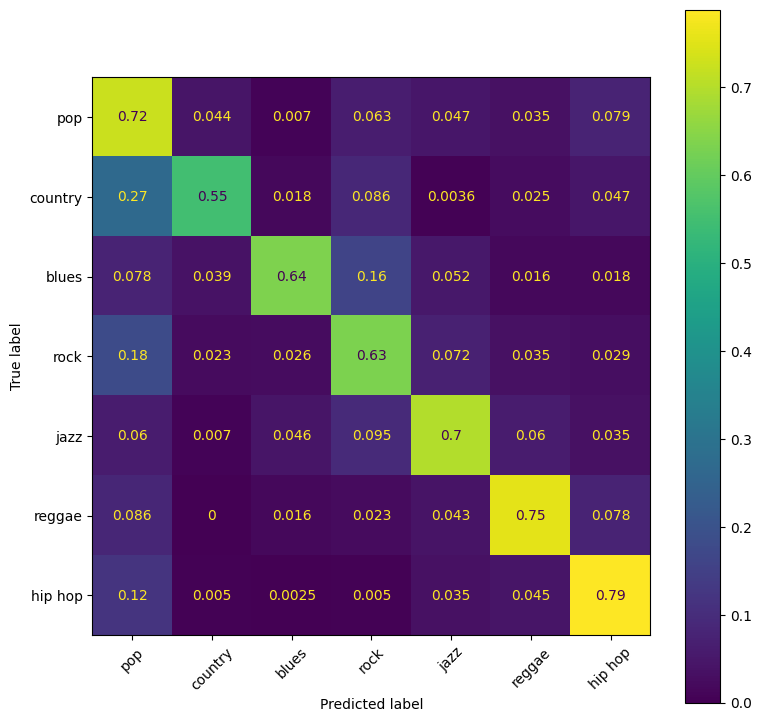

In [106]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pylab as plt
fig, ax  = plt.subplots(figsize=(9, 9))
disp = ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize='true', ax=ax)
ax.xaxis.set_ticklabels(list(dict_genres.keys()))
ax.yaxis.set_ticklabels(list(dict_genres.keys()))
ax.xaxis.set_tick_params(rotation=45)